<a href="https://colab.research.google.com/github/JessicaVieiraKah/sitema-de-recomendacao/blob/main/sistema_de_recomendacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalar as bibliotecas necessárias
!pip install tensorflow opencv-python

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity


In [5]:
# Carregar o dataset Fashion-MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar as imagens
train_images = train_images / 255.0
test_images = test_images / 255.0

# Adicionar uma dimensão extra para as imagens (já que são em escala de cinza)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Definindo as classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


4422102/4422102 [==============================] - 0s 0us/step


In [6]:
# Definindo o modelo CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Treinamento
model.fit(train_images, train_labels, epochs=10, validation_split=0.2)


Epoch 1/10
1500/1500 [==============================] - 57s 37ms/step - loss: 0.5940 - accuracy: 0.7817 - val_loss: 0.4318 - val_accuracy: 0.8397
Epoch 2/10
1500/1500 [==============================] - 55s 37ms/step - loss: 0.3977 - accuracy: 0.8545 - val_loss: 0.3790 - val_accuracy: 0.8623
Epoch 3/10
1500/1500 [==============================] - 55s 36ms/step - loss: 0.3369 - accuracy: 0.8747 - val_loss: 0.3456 - val_accuracy: 0.8720
Epoch 4/10
1500/1500 [==============================] - 53s 35ms/step - loss: 0.3004 - accuracy: 0.8886 - val_loss: 0.3031 - val_accuracy: 0.8895
Epoch 5/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.2674 - accuracy: 0.9016 - val_loss: 0.3319 - val_accuracy: 0.8765
Epoch 6/10
1500/1500 [==============================] - 58s 38ms/step - loss: 0.2436 - accuracy: 0.9102 - val_loss: 0.3468 - val_accuracy: 0.8777
Epoch 7/10
1500/1500 [==============================] - 54s 36ms/step - loss: 0.2243 - accuracy: 0.9159 - val_loss: 0.3436 -

In [7]:
# Função para extrair features das imagens
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-2].output)

def extract_features(image):
    image = np.expand_dims(image, axis=0)
    return feature_extractor.predict(image)

# Extraindo features de todas as imagens de treinamento
train_features = np.array([extract_features(img) for img in train_images])


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 147ms/step


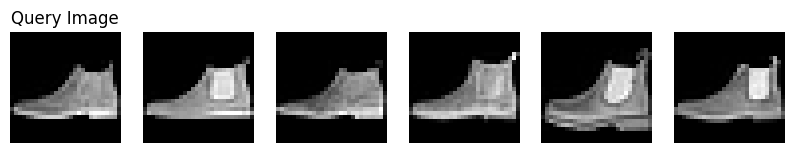

In [10]:
# Função para encontrar imagens similares
def find_similar_images(query_image, k=5):
    query_features = extract_features(query_image).reshape(1, -1)
    # Reshape train_features to 2D
    train_features_2d = train_features.reshape(train_features.shape[0], -1)
    similarities = cosine_similarity(query_features, train_features_2d)
    similar_indices = np.argsort(similarities[0])[::-1][:k]
    return [train_images[i] for i in similar_indices]

# Exemplo de uso
query_image = test_images[0]  # Usar uma imagem de teste como exemplo
similar_images = find_similar_images(query_image)

# Visualizando resultados
# Make sure you have imported matplotlib.pyplot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 6, 1)
plt.imshow(query_image.squeeze(), cmap='gray')
plt.title('Query Image')
plt.axis('off')

for i, img in enumerate(similar_images):
    plt.subplot(1, 6, i+2)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

plt.show()


In [13]:
!pip install flask flask-ngrok


In [14]:
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok
import cv2
import numpy as np

app = Flask(__name__)
run_with_ngrok(app)  # Adicionar ngrok ao Flask

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        file = request.files['file']
        if file:
            image_path = './uploaded_image.png'
            file.save(image_path)
            query_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            query_image = cv2.resize(query_image, (28, 28))
            query_image = query_image / 255.0
            query_image = np.expand_dims(query_image, axis=-1)
            similar_images = find_similar_images(query_image)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 6, 1)
            plt.imshow(query_image.squeeze(), cmap='gray')
            plt.title('Query Image')
            plt.axis('off')

            for i, img in enumerate(similar_images):
                plt.subplot(1, 6, i+2)
                plt.imshow(img.squeeze(), cmap='gray')
                plt.axis('off')

            plt.show()

            return "Similar images displayed in the output section."

    return '''
    <h1>Upload a Fashion Item Image</h1>
    <form method="post" enctype="multipart/form-data">
      <input type="file" name="file">
      <input type="submit" value="Upload">
    </form>
    '''

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-12:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [15]:
from flask import Flask, request, render_template
from flask_ngrok import run_with_ngrok
import cv2
import numpy as np
import matplotlib.pyplot as plt

app = Flask(__name__)
run_with_ngrok(app)  # Adicionar ngrok ao Flask

# Reutilizando as funções e o modelo do exemplo anterior
def extract_features(image):
    image = np.expand_dims(image, axis=0)
    features = feature_extractor.predict(image)
    return features.flatten()

def find_similar_images(query_image, k=5):
    query_features = extract_features(query_image).reshape(1, -1)
    similarities = cosine_similarity(query_features, train_features)
    similar_indices = np.argsort(similarities[0])[::-1][:k]
    return [train_images[i] for i in similar_indices]

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        file = request.files['file']
        if file:
            image_path = './uploaded_image.png'
            file.save(image_path)
            query_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            query_image = cv2.resize(query_image, (28, 28))
            query_image = query_image / 255.0
            query_image = np.expand_dims(query_image, axis=-1)
            similar_images = find_similar_images(query_image)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 6, 1)
            plt.imshow(query_image.squeeze(), cmap='gray')
            plt.title('Query Image')
            plt.axis('off')

            for i, img in enumerate(similar_images):
                plt.subplot(1, 6, i+2)
                plt.imshow(img.squeeze(), cmap='gray')
                plt.axis('off')

            plt.show()

            return "Similar images displayed in the output section."

    return '''
    <h1>Upload a Fashion Item Image</h1>
    <form method="post" enctype="multipart/form-data">
      <input type="file" name="file">
      <input type="submit" value="Upload">
    </form>
    '''

if __name__ == '__main__':
    app.run()


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 203, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 791, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll